# Store Item Demand Forecasting

Iniitally, I will use time series to do the forecast.  Later on I will try to discover any opportunity for explanatory models.

To install lightgbm : 
```conda install -c conda-forge lightgbm```

In [1]:
# import libraries

from datetime import datetime
import pandas as pd
import numpy as np

from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
#from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

from fbprophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt


## Preparing Data

In [2]:
# load data

df = pd.read_csv('train.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
df['date'] = df['date'].astype('datetime64[ns]')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.week
df['quarter'] = df['date'].dt.quarter
df['yearmonth'] = df['date'].dt.year * 100 + df['date'].dt.month
print(df.head())
print('\n')
print(df.info())


        date  store  item  sales  year  month  week  quarter  yearmonth
0 2013-01-01      1     1     13  2013      1     1        1     201301
1 2013-01-02      1     1     11  2013      1     1        1     201301
2 2013-01-03      1     1     14  2013      1     1        1     201301
3 2013-01-04      1     1     13  2013      1     1        1     201301
4 2013-01-05      1     1     10  2013      1     1        1     201301


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 9 columns):
date         913000 non-null datetime64[ns]
store        913000 non-null int64
item         913000 non-null int64
sales        913000 non-null int64
year         913000 non-null int64
month        913000 non-null int64
week         913000 non-null int64
quarter      913000 non-null int64
yearmonth    913000 non-null int64
dtypes: datetime64[ns](1), int64(8)
memory usage: 62.7 MB
None


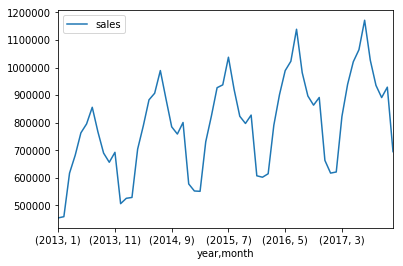

In [4]:
df.groupby(['year', 'month'], as_index = False).agg({'sales': 'sum'}).plot(x = ['year', 'month'], y = 'sales')

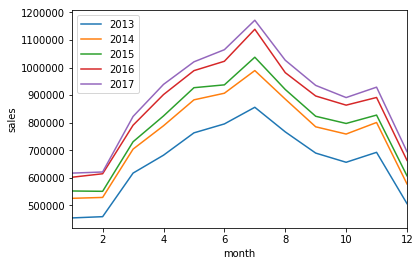

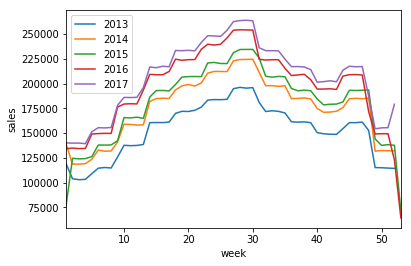

In [5]:
# monthly basis
fig, ax = plt.subplots()
for key, grp in df.groupby(['year']):
    ax = grp.groupby('month', as_index = False).agg({'sales': 'sum'}).plot(ax = ax, kind = 'line', x = 'month', y = 'sales', label = key)

plt.xlabel('month')
plt.ylabel('sales')
plt.show()

# weekly basis
fig, ax = plt.subplots()
for key, grp in df.groupby(['year']):
    ax = grp.groupby('week', as_index = False).agg({'sales': 'sum'}).plot(ax = ax, kind = 'line', x = 'week', y = 'sales', label = key)

plt.xlabel('week')
plt.ylabel('sales')
plt.show()

The data plots show a seasonal pattern with up trend.

### Using Autoregression

Have a quick check whether has a autocorrelation in the dataset with Pandas lag_plot() function.

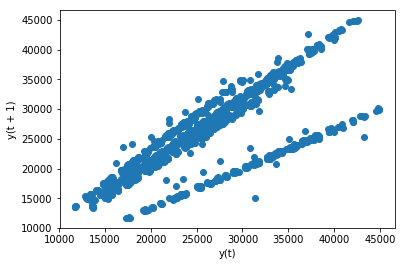

In [6]:
from pandas import Series
from pandas.plotting import lag_plot, autocorrelation_plot
df2 = df.groupby('date').agg({'sales' : 'sum'})
lag_plot(df2)

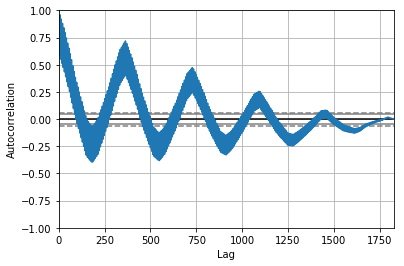

In [7]:
autocorrelation_plot(df2)

In [8]:
# split data into train and test
# only 1 product in 1 store is selected 

df2 = df[(df.store == 1) & (df.item == 1)]

X_train = df2.iloc[:len(df2)-7, 0:1].values
y_train = df2.iloc[:len(df2)-7, 3:4].values

X_test = df2.iloc[len(df2)-7:, 0:1].values
y_test = df2.iloc[len(df2)-7:, 3:4].values


Test MSE: 0.000


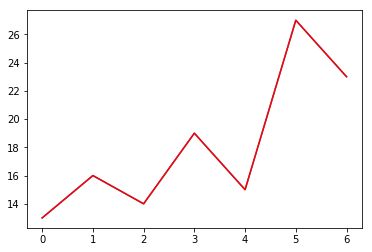

In [9]:
# baseline

def model_persistence(x):
    return x

predictions = list()

for y in y_test:
    yhat = model_persistence(y)
    predictions.append(yhat)

test_score = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % test_score)

plt.plot(y_test)
plt.plot(predictions, color='red')
plt.show()

Log: 25
Coefficients: [ 1.70951976  0.10123034  0.03655369  0.04350589  0.05798021  0.0527645
  0.05423115  0.2297525   0.00841652  0.01634452  0.02925363 -0.02298118
 -0.00492292  0.02807545  0.20150254  0.01116887 -0.01138532 -0.03046041
  0.00839954 -0.00990897  0.02903417  0.13699674  0.0417866  -0.02488224
 -0.04467598 -0.02182408]
Predicted = 16.366413, Expected = 13.000000
Predicted = 12.682308, Expected = 16.000000
Predicted = 15.659011, Expected = 14.000000
Predicted = 14.615890, Expected = 19.000000
Predicted = 14.219262, Expected = 15.000000
Predicted = 17.988385, Expected = 27.000000
Predicted = 19.104606, Expected = 23.000000
Test MSE: 20.186


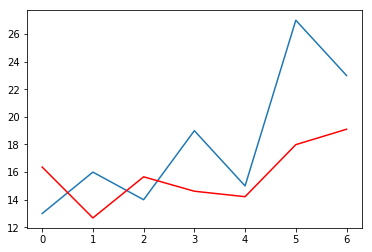

In [10]:
model = AR(y_train)
model_fit = model.fit()
print('Log: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, dynamic=False)
for i in range(len(predictions)):
    print('Predicted = %f, Expected = %f' % (predictions[i], y_test[i]))
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % error)

# plot result
plt.plot(y_test)
plt.plot(predictions, color='red')
plt.show()

### Big Model

In [11]:
# add 2 features, t-1 sales and the different

df2 = df.copy()
df2['last_sales'] = df2.groupby(['store', 'item'])['sales'].shift()
df2['last_sales_diff'] = df2.groupby(['store', 'item'])['last_sales'].diff()
df2 = df2.dropna()
df2.head()


,date,store,item,sales,year,month,week,quarter,yearmonth,last_sales,last_sales_diff
2,2013-01-03,1,1,14,2013,1,1,1,201301,11.0,-2.0
3,2013-01-04,1,1,13,2013,1,1,1,201301,14.0,3.0
4,2013-01-05,1,1,10,2013,1,1,1,201301,13.0,-1.0
5,2013-01-06,1,1,12,2013,1,1,1,201301,10.0,-3.0
6,2013-01-07,1,1,10,2013,1,2,1,201301,12.0,2.0


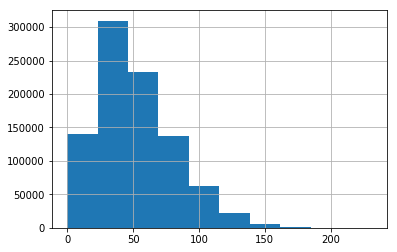

In [12]:
df2['sales'].hist()

Use Root Mean Squared Log Error as a benchmark. 

In [13]:
def rmsle(y, yhat):
    return np.sqrt(mean_squared_log_error(y, yhat))

mean_error = []
for ym in df2['yearmonth'].unique().tolist():
    r = df2[df2['yearmonth'] == ym]
    p = r['last_sales'].values
    err = rmsle(r['sales'].values, p)
    print('%d : %.5f' % (ym, err))
    mean_error.append(err)
print(np.mean(mean_error))

201301 : 0.33203
201302 : 0.32616
201303 : 0.29820
201304 : 0.29770
201305 : 0.28257
201306 : 0.27731
201307 : 0.27327
201308 : 0.27798
201309 : 0.29542
201310 : 0.29165
201311 : 0.28509
201312 : 0.33530
201401 : 0.31822
201402 : 0.31094
201403 : 0.29971
201404 : 0.28119
201405 : 0.26632
201406 : 0.27264
201407 : 0.26096
201408 : 0.26529
201409 : 0.28808
201410 : 0.28140
201411 : 0.27546
201412 : 0.33187
201501 : 0.30878
201502 : 0.30752
201503 : 0.29677
201504 : 0.27373
201505 : 0.26282
201506 : 0.26932
201507 : 0.25071
201508 : 0.27328
201509 : 0.26913
201510 : 0.27632
201511 : 0.28302
201512 : 0.30585
201601 : 0.30121
201602 : 0.29747
201603 : 0.27846
201604 : 0.26904
201605 : 0.26990
201606 : 0.25557
201607 : 0.24796
201608 : 0.27570
201609 : 0.26263
201610 : 0.27687
201611 : 0.26746
201612 : 0.29515
201701 : 0.30838
201702 : 0.29743
201703 : 0.27717
201704 : 0.26408
201705 : 0.26453
201706 : 0.25003
201707 : 0.25574
201708 : 0.25705
201709 : 0.25872
201710 : 0.27444
201711 : 0.262

Use LightGBM

In [14]:
print(datetime.now())

mean_error = []
for ym in df2['yearmonth'].unique()[48:].tolist():
    train = df2[df2['yearmonth'] < ym]
    test = df2[df2['yearmonth'] == ym]
    
    X_train = train.drop(['date', 'year', 'month', 'week', 'quarter', 'sales'], axis=1)
    X_test = test.drop(['date', 'year', 'month', 'week', 'quarter', 'sales'], axis=1)
    y_train, y_test = train['sales'].values, test['sales'].values
    
    lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.1)
    lgbm.fit(X_train, np.log1p(y_train))
    p = np.expm1(lgbm.predict(X_test))
    
    err = rmsle(y_test, p)
    print('%d : %.5f' % (ym, err))
    mean_error.append(err)
print(np.mean(mean_error))

print(datetime.now())


2018-07-27 22:39:51.722520
201701 : 0.23216
201702 : 0.23224
201703 : 0.25812
201704 : 0.24728
201705 : 0.19766
201706 : 0.19439
201707 : 0.19581
201708 : 0.21529
201709 : 0.19628
201710 : 0.21276
201711 : 0.19899
201712 : 0.32339
0.225364505617
2018-07-27 22:42:41.869011


The error rate is improved 0.06 but still high.

### Using Facebook Prophet
https://facebook.github.io/prophet/docs/quick_start.html

Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

Use the changepoint prior to adjust bias vs. variance.  The default value is 0.05.


2018-07-28 00:25:34.696028
201712 : 0.23870
201712 : 0.16681
201712 : 0.18073
201712 : 0.24633
201712 : 0.26839
201712 : 0.17392
201712 : 0.14690
201712 : 0.14137
201712 : 0.16832
201712 : 0.13256
201712 : 0.14800
201712 : 0.13612


KeyboardInterrupt: 

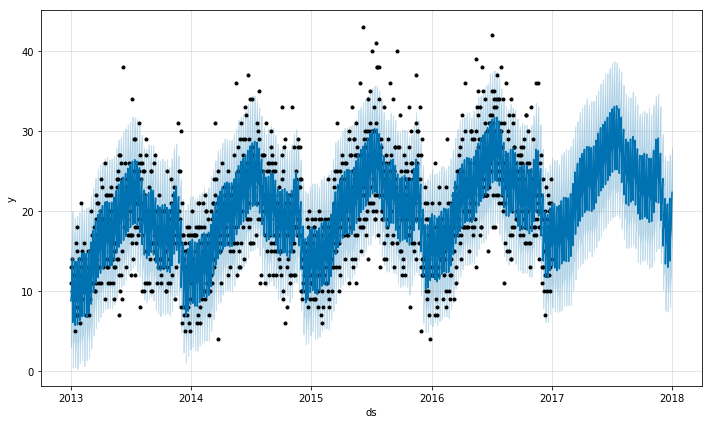

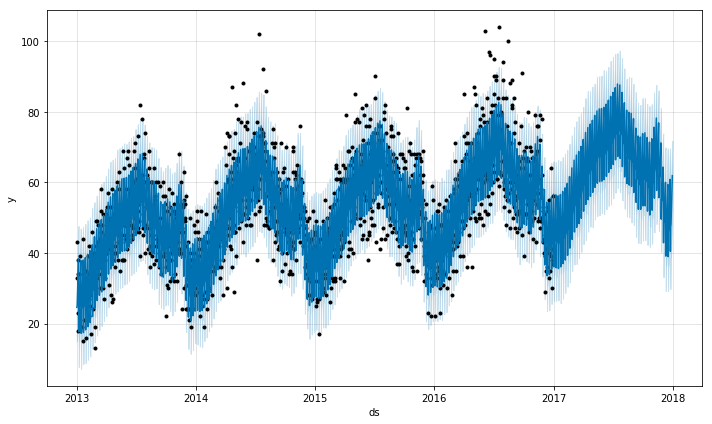

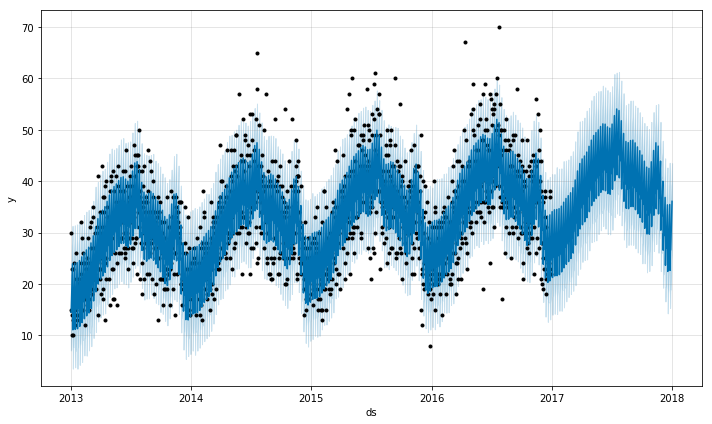

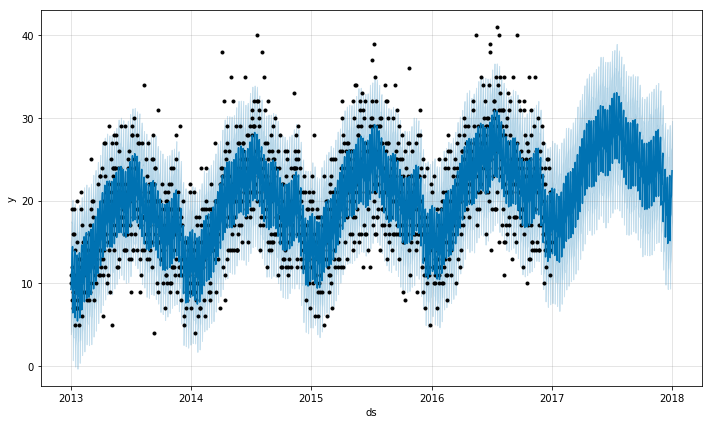

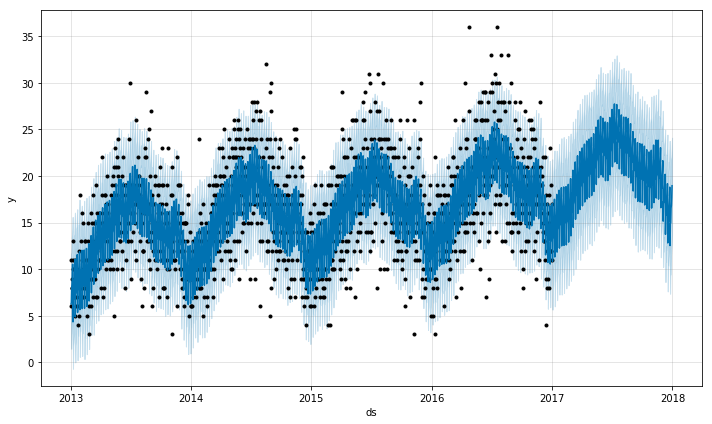

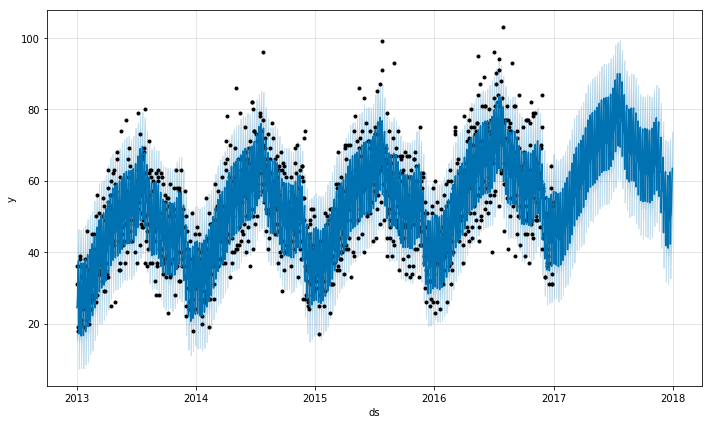

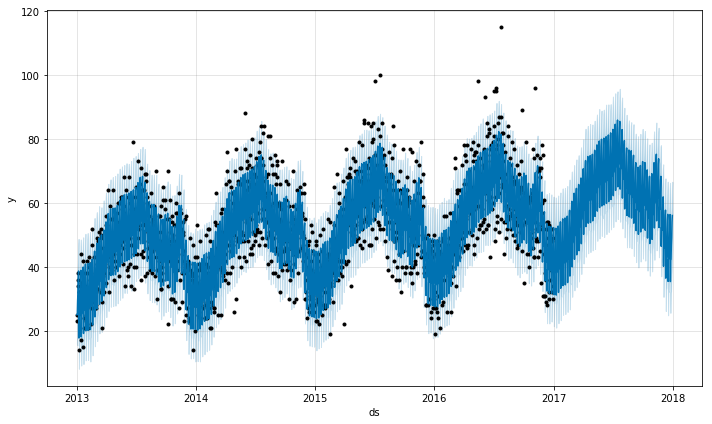

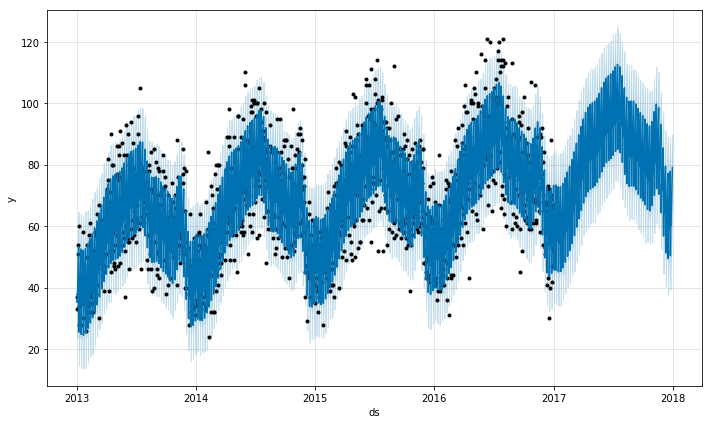

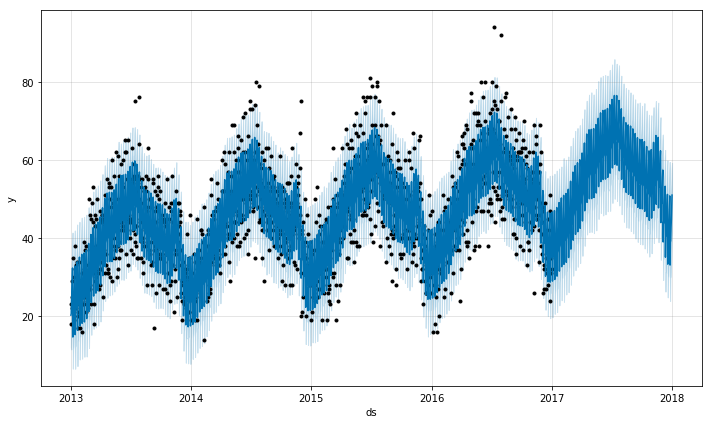

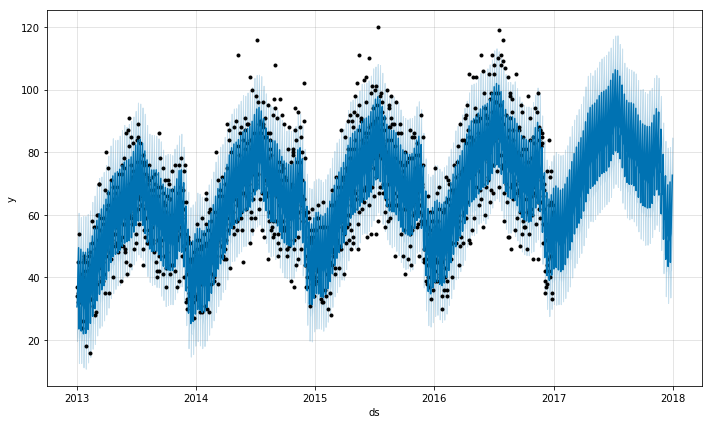

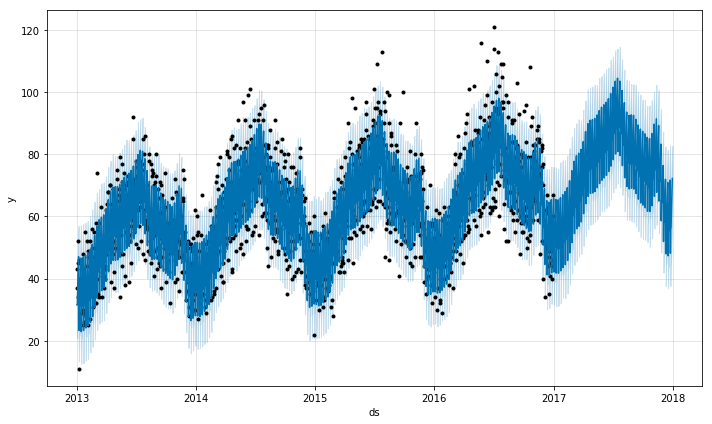

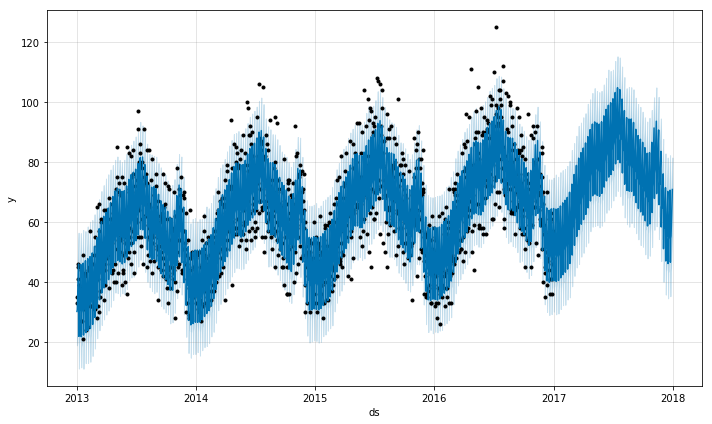

In [39]:
df3 = df.copy()
df3 = df3.rename(columns={'date':'ds', 'sales':'y'})

print(datetime.now())

mean_error = []
for s in range(len(df3.store.unique())):
    for i in range(len(df3.item.unique())):
        train = df3[(df3['store'] == s + 1) & (df3['item'] == i + 1) & (df3['year'] < 2017)]
        test = df3[(df3['store'] == s + 1) & (df3['item'] == i + 1) & (df3['year'] == 2017)]
        X_train = train.drop(['store', 'item', 'year', 'month', 'week', 'quarter', 'yearmonth'], axis=1)
        X_test = test.drop(['store', 'item', 'year', 'month', 'week', 'quarter', 'yearmonth'], axis=1)
        y_train = train['y'].values
        y_test = test['y'].values

        fbp = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True)
        fbp.fit(X_train)
        future = fbp.make_future_dataframe(periods=365, freq='D')
        forecast = fbp.predict(future)
        
        p = forecast[forecast['ds'] >= '2017-01-01']
        err = rmsle(y_test, p['yhat'].values)
#        print('%d, %d : %.5f' % (s+1, i+1, err))
        mean_error.append(err)
        fbp.plot(forecast)
        
print(np.mean(mean_error))


print(datetime.now())


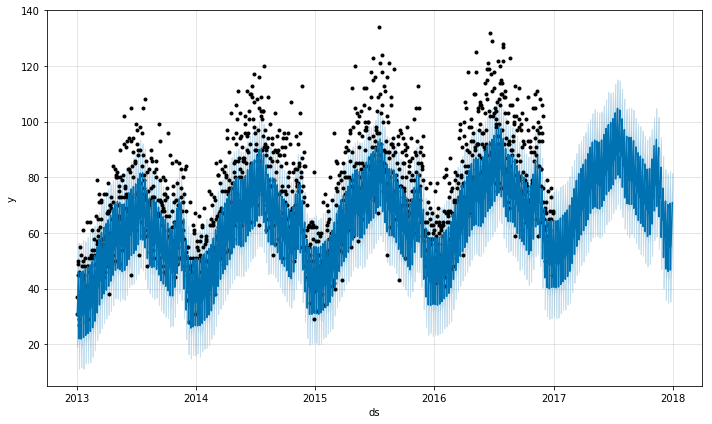

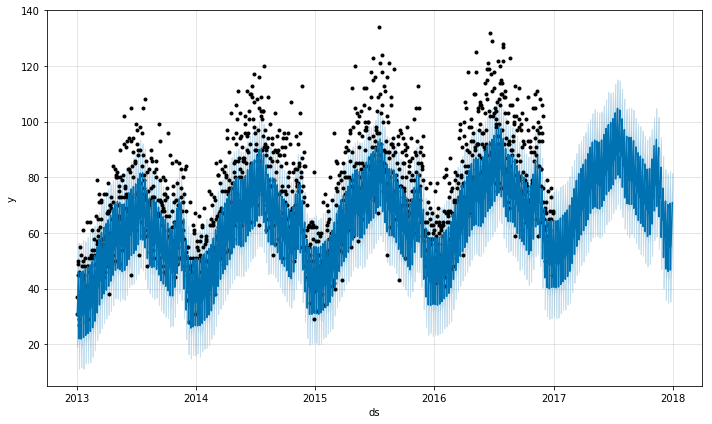

In [40]:
fbp.plot(forecast)

In [26]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2013-01-01,19.680162,19.680162,19.680162,-3.878212,59.421773,6.961643,6.961643,6.961643,26.727583,...,0.0,0.0,0.0,-3.992204,-3.992204,-3.992204,-15.773736,-15.773736,-15.773736,26.641805
1,2013-01-01,19.680162,19.680162,19.680162,-7.822393,61.227451,6.961643,6.961643,6.961643,26.727583,...,0.0,0.0,0.0,-3.992204,-3.992204,-3.992204,-15.773736,-15.773736,-15.773736,26.641805
2,2013-01-01,19.680162,19.680162,19.680162,-7.316079,58.825050,6.961643,6.961643,6.961643,26.727583,...,0.0,0.0,0.0,-3.992204,-3.992204,-3.992204,-15.773736,-15.773736,-15.773736,26.641805
3,2013-01-01,19.680162,19.680162,19.680162,-7.196923,57.158036,6.961643,6.961643,6.961643,26.727583,...,0.0,0.0,0.0,-3.992204,-3.992204,-3.992204,-15.773736,-15.773736,-15.773736,26.641805
4,2013-01-01,19.680162,19.680162,19.680162,-5.354766,61.018915,6.961643,6.961643,6.961643,26.727583,...,0.0,0.0,0.0,-3.992204,-3.992204,-3.992204,-15.773736,-15.773736,-15.773736,26.641805


In [41]:
mean_error

[0.23870116522531323,
 0.16680764211515212,
 0.18073453178325394,
 0.24632988240747111,
 0.26839269456679776,
 0.17392346882388435,
 0.14690476503339867,
 0.14137465326556337,
 0.16831581157371828,
 0.13256320467497856,
 0.14800069153265202,
 0.13611520015093201]

In [27]:
X_train.head()

,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


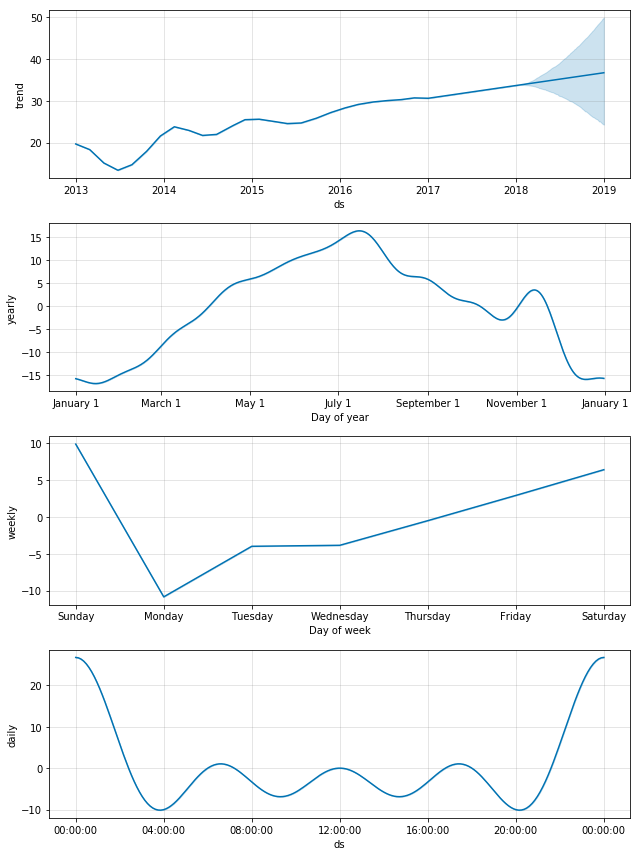

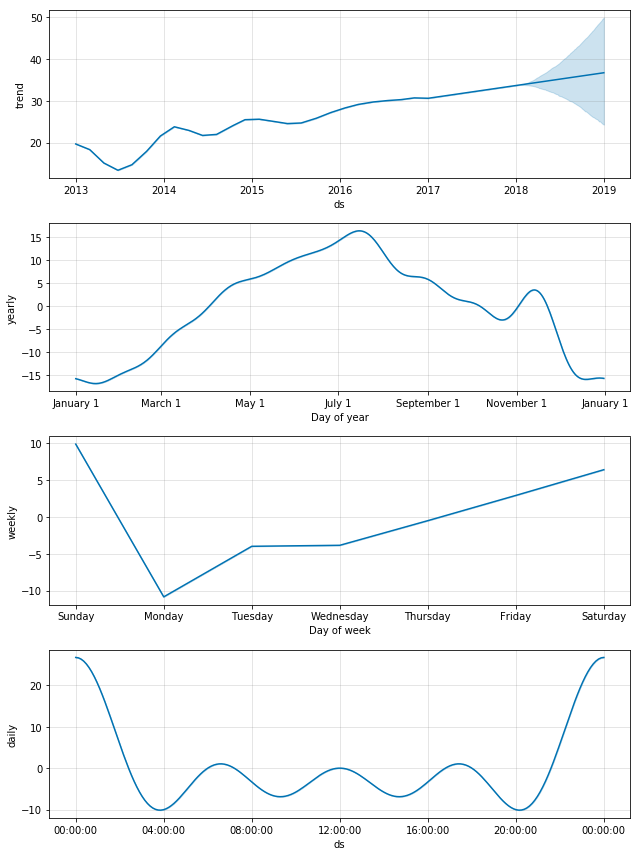

In [28]:
fbp.plot_components(forecast)

In [31]:
X_train.tail()

,ds,y
912995,2017-12-27,63
912996,2017-12-28,59
912997,2017-12-29,74
912998,2017-12-30,62
912999,2017-12-31,82
